In [1]:
import yaml

import gc

from approx_thresh_general import tpr, fpr, precision

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

from pipeline import FairDataset, FairPipeline, accuracy, f1

import pandas as pd

import warnings
warnings.filterwarnings("ignore")

my_classifiers = {
    # 'logistic_regression': LogisticRegression(),
    # 'random_forest': RandomForestClassifier(),
    # 'gradient_boosting': GradientBoostingClassifier(),
    # 'svc': SVC(probability=True),
    'knn': KNeighborsClassifier(),
    # 'mlp': MLPClassifier()
    # decision tree
}

metrics_dict = {
    'tpr': tpr,
    'fpr': fpr,
    'precision': precision,
    'accuracy': accuracy,
    'f1': f1
}

metrics_functions = {
    'tpr': tpr,
    'fpr': fpr,
    'precision': precision,
}

pipeline = FairPipeline(classifiers=my_classifiers, 
                        classifier_config_path='configs/classifier_config.yml', 
                        metrics=metrics_dict,
                        metric_functions=metrics_functions)

X = pd.read_csv(f'matrices/ACSEmployment/Xs.csv')
y = pd.read_csv(f'matrices/ACSEmployment/ys.csv').squeeze()

acs_dataset = FairDataset(X, y, 'RAC1P_recoded')

In [2]:
# NOTE: Add loss column to the results dataframe
# NOTE: Add new config settings to the results dataframe

In [3]:
def load_config(config_path):
    with open(config_path, 'r') as file:
        config = yaml.safe_load(file)
    return config

CONFIG_PATH = 'configs/test_config.yml'

config = load_config(CONFIG_PATH)
datasets = config['datasets']
classifier_config_path = 'configs/classifier_config.yml'

# set to True to estimate runtime
ESTIMATE_RUNTIME = False

# here we estimate the runtime for the pipeline
if ESTIMATE_RUNTIME:
    total_runtime = 0
    for dataset_name, sensitive_attrs in datasets.items():
        print(f"Estimating runtime for dataset: {dataset_name}")
        if dataset_name in ('ACSEmployment','ACSIncome','ACSMobility','ACSPublicCoverage','ACSTravelTime'):
            X = pd.read_csv(f'matrices/{dataset_name}/Xs.csv')
            y = pd.read_csv(f'matrices/{dataset_name}/ys.csv').squeeze()
        else:
            X = pd.read_csv(f'matrices/{dataset_name}/X.csv')
            y = pd.read_csv(f'matrices/{dataset_name}/y.csv').squeeze()

        # remove any rows that have null or nan
        X.dropna(inplace=True)
        y = y[X.index]

        dataset = FairDataset(X, y, sensitive_attrs)

        for sensitive_attr in sensitive_attrs:
            pipeline = FairPipeline(classifiers=my_classifiers, 
                                    classifier_config_path=classifier_config_path, 
                                    metrics=metrics_dict,
                                    metric_functions=metrics_functions,
                                    max_error=0.01, max_total_combinations=1000)

            runtime = pipeline.estimate_runtime(dataset, sensitive_attr)
            total_runtime += runtime

        del X, y, dataset
        gc.collect()
        print()

    print(f"Total estimated runtime for all datasets and sensitive attributes: {total_runtime:.2f} seconds")

proceed = input("Do you want to proceed with the full pipeline run? (yes/no): ").strip().lower()

if proceed == 'yes':
    print("Running the full pipeline...")
    all_results = pd.DataFrame()
    for dataset_name, sensitive_attrs in datasets.items():
        print(f"Running pipeline for dataset: {dataset_name}")
        if dataset_name in ('ACSEmployment','ACSIncome','ACSMobility','ACSPublicCoverage','ACSTravelTime'):
            X = pd.read_csv(f'matrices/{dataset_name}/Xs.csv')
            y = pd.read_csv(f'matrices/{dataset_name}/ys.csv').squeeze()
        else:
            X = pd.read_csv(f'matrices/{dataset_name}/X.csv')
            y = pd.read_csv(f'matrices/{dataset_name}/y.csv').squeeze()

        # remove any rows that have null or nan
        X.dropna(inplace=True)
        y = y[X.index]

        dataset = FairDataset(X, y, sensitive_attrs)

        for sensitive_attr in sensitive_attrs:
            pipeline = FairPipeline(classifiers=my_classifiers, 
                                    classifier_config_path=classifier_config_path, 
                                    metrics=metrics_dict,
                                    metric_functions=metrics_functions,
                                    max_error=0.01, max_total_combinations=1000)

            pipeline.tune_and_evaluate(dataset, dataset_name, sensitive_attr)
            results = pipeline.results_df
            results['sensitive_attr'] = sensitive_attr
            results['dataset'] = dataset_name
            all_results = all_results.append(results, ignore_index=True)
            
        # this avoids memory issues
        del X, y, dataset
        gc.collect()

    print("Pipeline run completed.")
else:
    print("Pipeline run aborted.")

# dump all results to pickle dataframe
all_results.to_pickle('all_results.pkl')


Running the full pipeline...
Running pipeline for dataset: ACSEmployment
Overall metrics for knn (original): {'tpr': 0.8596976793698106, 'fpr': 0.2247670807453416, 'precision': 0.7771362586605081, 'accuracy': 0.8155142654076556, 'f1': 0.8163347821692105}
Hyperparameters: {'n_neighbors': 20, 'weights': 'uniform'}
Metrics for knn (original) on 1: {'tpr': 0.8596648713345302, 'fpr': 0.2158899494665918, 'precision': 0.7888522789676002, 'accuracy': 0.820683661645423, 'f1': 0.822737686139748}
Hyperparameters: {'n_neighbors': 20, 'weights': 'uniform'}
Metrics for knn (original) on 2: {'tpr': 0.8485401459854015, 'fpr': 0.23529411764705882, 'precision': 0.7536466774716369, 'accuracy': 0.8031825795644891, 'f1': 0.7982832618025751}
Hyperparameters: {'n_neighbors': 20, 'weights': 'uniform'}
Metrics for knn (original) on 3: {'tpr': 0.8624708624708625, 'fpr': 0.28054298642533937, 'precision': 0.7489878542510121, 'accuracy': 0.7898966704936854, 'f1': 0.8017334777898159}
Hyperparameters: {'n_neighbors'

Threshold Combinations: 100%|██████████| 2401/2401 [00:08<00:00, 268.77it/s]


Best objective value: 0.4565350594647406
Best thresholds: {1: 0.3333333333333333, 2: 0.3333333333333333, 3: 0.3333333333333333, 4: 0.3333333333333333}
Epsilon differences: {1: {2: array([0.00958384, 0.01456986, 0.02694678]), 3: array([0.02277017, 0.03421739, 0.00925036]), 4: array([0.01697966, 0.00732947, 0.04529046])}, 2: {1: array([0.00958384, 0.01456986, 0.02694678]), 3: array([0.01318633, 0.01964754, 0.01769641]), 4: array([0.00739582, 0.00724039, 0.01834369])}, 3: {1: array([0.02277017, 0.03421739, 0.00925036]), 2: array([0.01318633, 0.01964754, 0.01769641]), 4: array([0.00579051, 0.02688792, 0.0360401 ])}, 4: {1: array([0.01697966, 0.00732947, 0.04529046]), 2: array([0.00739582, 0.00724039, 0.01834369]), 3: array([0.00579051, 0.02688792, 0.0360401 ])}}
Overall metrics for knn (fair): {'tpr': 0.9584841388120077, 'fpr': 0.31288819875776397, 'precision': 0.7363428197579326, 'accuracy': 0.8165295969133922, 'f1': 0.8328554250300619}
Hyperparameters: {'n_neighbors': 20, 'weights': 'uni

Threshold Combinations: 100%|██████████| 2401/2401 [00:08<00:00, 298.91it/s]


Best objective value: 0.49322914008206215
Best thresholds: {1: 0.3333333333333333, 2: 0.3333333333333333, 3: 0.3333333333333333, 4: 0.3333333333333333}
Epsilon differences: {1: {2: array([0.00958384, 0.01456986, 0.02694678]), 3: array([0.02277017, 0.03421739, 0.00925036]), 4: array([0.01697966, 0.00732947, 0.04529046])}, 2: {1: array([0.00958384, 0.01456986, 0.02694678]), 3: array([0.01318633, 0.01964754, 0.01769641]), 4: array([0.00739582, 0.00724039, 0.01834369])}, 3: {1: array([0.02277017, 0.03421739, 0.00925036]), 2: array([0.01318633, 0.01964754, 0.01769641]), 4: array([0.00579051, 0.02688792, 0.0360401 ])}, 4: {1: array([0.01697966, 0.00732947, 0.04529046]), 2: array([0.00739582, 0.00724039, 0.01834369]), 3: array([0.00579051, 0.02688792, 0.0360401 ])}}
Overall metrics for knn (fair): {'tpr': 0.9584841388120077, 'fpr': 0.31288819875776397, 'precision': 0.7363428197579326, 'accuracy': 0.8165295969133922, 'f1': 0.8328554250300619}
Hyperparameters: {'n_neighbors': 20, 'weights': 'un

Threshold Combinations: 100%|██████████| 2401/2401 [00:10<00:00, 230.07it/s]


Best objective value: 0.5299232206993837
Best thresholds: {1: 0.3333333333333333, 2: 0.3333333333333333, 3: 0.3333333333333333, 4: 0.3333333333333333}
Epsilon differences: {1: {2: array([0.00958384, 0.01456986, 0.02694678]), 3: array([0.02277017, 0.03421739, 0.00925036]), 4: array([0.01697966, 0.00732947, 0.04529046])}, 2: {1: array([0.00958384, 0.01456986, 0.02694678]), 3: array([0.01318633, 0.01964754, 0.01769641]), 4: array([0.00739582, 0.00724039, 0.01834369])}, 3: {1: array([0.02277017, 0.03421739, 0.00925036]), 2: array([0.01318633, 0.01964754, 0.01769641]), 4: array([0.00579051, 0.02688792, 0.0360401 ])}, 4: {1: array([0.01697966, 0.00732947, 0.04529046]), 2: array([0.00739582, 0.00724039, 0.01834369]), 3: array([0.00579051, 0.02688792, 0.0360401 ])}}
Overall metrics for knn (fair): {'tpr': 0.9584841388120077, 'fpr': 0.31288819875776397, 'precision': 0.7363428197579326, 'accuracy': 0.8165295969133922, 'f1': 0.8328554250300619}
Hyperparameters: {'n_neighbors': 20, 'weights': 'uni

Threshold Combinations: 100%|██████████| 2401/2401 [00:09<00:00, 244.58it/s]


Best objective value: 0.5666173013167053
Best thresholds: {1: 0.3333333333333333, 2: 0.3333333333333333, 3: 0.3333333333333333, 4: 0.3333333333333333}
Epsilon differences: {1: {2: array([0.00958384, 0.01456986, 0.02694678]), 3: array([0.02277017, 0.03421739, 0.00925036]), 4: array([0.01697966, 0.00732947, 0.04529046])}, 2: {1: array([0.00958384, 0.01456986, 0.02694678]), 3: array([0.01318633, 0.01964754, 0.01769641]), 4: array([0.00739582, 0.00724039, 0.01834369])}, 3: {1: array([0.02277017, 0.03421739, 0.00925036]), 2: array([0.01318633, 0.01964754, 0.01769641]), 4: array([0.00579051, 0.02688792, 0.0360401 ])}, 4: {1: array([0.01697966, 0.00732947, 0.04529046]), 2: array([0.00739582, 0.00724039, 0.01834369]), 3: array([0.00579051, 0.02688792, 0.0360401 ])}}
Overall metrics for knn (fair): {'tpr': 0.9584841388120077, 'fpr': 0.31288819875776397, 'precision': 0.7363428197579326, 'accuracy': 0.8165295969133922, 'f1': 0.8328554250300619}
Hyperparameters: {'n_neighbors': 20, 'weights': 'uni

Threshold Combinations: 100%|██████████| 2401/2401 [00:08<00:00, 282.01it/s]


Best objective value: 0.6033113819340268
Best thresholds: {1: 0.3333333333333333, 2: 0.3333333333333333, 3: 0.3333333333333333, 4: 0.3333333333333333}
Epsilon differences: {1: {2: array([0.00958384, 0.01456986, 0.02694678]), 3: array([0.02277017, 0.03421739, 0.00925036]), 4: array([0.01697966, 0.00732947, 0.04529046])}, 2: {1: array([0.00958384, 0.01456986, 0.02694678]), 3: array([0.01318633, 0.01964754, 0.01769641]), 4: array([0.00739582, 0.00724039, 0.01834369])}, 3: {1: array([0.02277017, 0.03421739, 0.00925036]), 2: array([0.01318633, 0.01964754, 0.01769641]), 4: array([0.00579051, 0.02688792, 0.0360401 ])}, 4: {1: array([0.01697966, 0.00732947, 0.04529046]), 2: array([0.00739582, 0.00724039, 0.01834369]), 3: array([0.00579051, 0.02688792, 0.0360401 ])}}
Overall metrics for knn (fair): {'tpr': 0.9584841388120077, 'fpr': 0.31288819875776397, 'precision': 0.7363428197579326, 'accuracy': 0.8165295969133922, 'f1': 0.8328554250300619}
Hyperparameters: {'n_neighbors': 20, 'weights': 'uni

Threshold Combinations: 100%|██████████| 625/625 [00:03<00:00, 160.46it/s]


Best objective value: 0.09383337173330475
Best thresholds: {1.0: 0.625, 2.0: 0.625}
Epsilon differences: {1.0: {2.0: array([0.02182759, 0.0093497 , 0.02935704])}, 2.0: {1.0: array([0.02182759, 0.0093497 , 0.02935704])}}
Overall metrics for knn (fair): {'tpr': 0.6961890568447946, 'fpr': 0.07317546583850931, 'precision': 0.8966273649574993, 'accuracy': 0.8168341963651132, 'f1': 0.783796740172579}
Hyperparameters: {'n_neighbors': 20, 'weights': 'uniform'}
Metrics for knn (fair) on 1.0: {'tpr': 0.7072538860103627, 'fpr': 0.06806506849315068, 'precision': 0.9115191986644408, 'accuracy': 0.8200773860705073, 'f1': 0.7964989059080962}
Hyperparameters: {'n_neighbors': 20, 'weights': 'uniform'}
Metrics for knn (fair) on 2.0: {'tpr': 0.6854262914741706, 'fpr': 0.07741477272727272, 'precision': 0.8821621621621621, 'accuracy': 0.813931114104291, 'f1': 0.7714488300638147}
Hyperparameters: {'n_neighbors': 20, 'weights': 'uniform'}
Number of points in the epsilon net: 27
Adjusted max_error: 0.01
Numbe

Threshold Combinations: 100%|██████████| 729/729 [00:04<00:00, 154.34it/s]


Best objective value: 0.1304665324602821
Best thresholds: {1.0: 0.6153846153846154, 2.0: 0.6153846153846154}
Epsilon differences: {1.0: {2.0: array([0.02182759, 0.0093497 , 0.02935704])}, 2.0: {1.0: array([0.02182759, 0.0093497 , 0.02935704])}}
Overall metrics for knn (fair): {'tpr': 0.6961890568447946, 'fpr': 0.07317546583850931, 'precision': 0.8966273649574993, 'accuracy': 0.8168341963651132, 'f1': 0.783796740172579}
Hyperparameters: {'n_neighbors': 20, 'weights': 'uniform'}
Metrics for knn (fair) on 1.0: {'tpr': 0.7072538860103627, 'fpr': 0.06806506849315068, 'precision': 0.9115191986644408, 'accuracy': 0.8200773860705073, 'f1': 0.7964989059080962}
Hyperparameters: {'n_neighbors': 20, 'weights': 'uniform'}
Metrics for knn (fair) on 2.0: {'tpr': 0.6854262914741706, 'fpr': 0.07741477272727272, 'precision': 0.8821621621621621, 'accuracy': 0.813931114104291, 'f1': 0.7714488300638147}
Hyperparameters: {'n_neighbors': 20, 'weights': 'uniform'}
Number of points in the epsilon net: 29
Adjus

Threshold Combinations: 100%|██████████| 841/841 [00:04<00:00, 196.63it/s]


Best objective value: 0.16709969318725945
Best thresholds: {1.0: 0.6071428571428571, 2.0: 0.6071428571428571}
Epsilon differences: {1.0: {2.0: array([0.02182759, 0.0093497 , 0.02935704])}, 2.0: {1.0: array([0.02182759, 0.0093497 , 0.02935704])}}
Overall metrics for knn (fair): {'tpr': 0.6961890568447946, 'fpr': 0.07317546583850931, 'precision': 0.8966273649574993, 'accuracy': 0.8168341963651132, 'f1': 0.783796740172579}
Hyperparameters: {'n_neighbors': 20, 'weights': 'uniform'}
Metrics for knn (fair) on 1.0: {'tpr': 0.7072538860103627, 'fpr': 0.06806506849315068, 'precision': 0.9115191986644408, 'accuracy': 0.8200773860705073, 'f1': 0.7964989059080962}
Hyperparameters: {'n_neighbors': 20, 'weights': 'uniform'}
Metrics for knn (fair) on 2.0: {'tpr': 0.6854262914741706, 'fpr': 0.07741477272727272, 'precision': 0.8821621621621621, 'accuracy': 0.813931114104291, 'f1': 0.7714488300638147}
Hyperparameters: {'n_neighbors': 20, 'weights': 'uniform'}
Number of points in the epsilon net: 31
Adju

Threshold Combinations: 100%|██████████| 961/961 [00:04<00:00, 202.48it/s]


Best objective value: 0.2037328539142368
Best thresholds: {1.0: 0.6333333333333333, 2.0: 0.6333333333333333}
Epsilon differences: {1.0: {2.0: array([0.02182759, 0.0093497 , 0.02935704])}, 2.0: {1.0: array([0.02182759, 0.0093497 , 0.02935704])}}
Overall metrics for knn (fair): {'tpr': 0.6961890568447946, 'fpr': 0.07317546583850931, 'precision': 0.8966273649574993, 'accuracy': 0.8168341963651132, 'f1': 0.783796740172579}
Hyperparameters: {'n_neighbors': 20, 'weights': 'uniform'}
Metrics for knn (fair) on 1.0: {'tpr': 0.7072538860103627, 'fpr': 0.06806506849315068, 'precision': 0.9115191986644408, 'accuracy': 0.8200773860705073, 'f1': 0.7964989059080962}
Hyperparameters: {'n_neighbors': 20, 'weights': 'uniform'}
Metrics for knn (fair) on 2.0: {'tpr': 0.6854262914741706, 'fpr': 0.07741477272727272, 'precision': 0.8821621621621621, 'accuracy': 0.813931114104291, 'f1': 0.7714488300638147}
Hyperparameters: {'n_neighbors': 20, 'weights': 'uniform'}
Adjusted max_error to 0.009986591149601182 to

Threshold Combinations: 100%|██████████| 1089/1089 [00:04<00:00, 232.48it/s]


Best objective value: 0.24036601464121415
Best thresholds: {1.0: 0.625, 2.0: 0.625}
Epsilon differences: {1.0: {2.0: array([0.02182759, 0.0093497 , 0.02935704])}, 2.0: {1.0: array([0.02182759, 0.0093497 , 0.02935704])}}
Overall metrics for knn (fair): {'tpr': 0.6961890568447946, 'fpr': 0.07317546583850931, 'precision': 0.8966273649574993, 'accuracy': 0.8168341963651132, 'f1': 0.783796740172579}
Hyperparameters: {'n_neighbors': 20, 'weights': 'uniform'}
Metrics for knn (fair) on 1.0: {'tpr': 0.7072538860103627, 'fpr': 0.06806506849315068, 'precision': 0.9115191986644408, 'accuracy': 0.8200773860705073, 'f1': 0.7964989059080962}
Hyperparameters: {'n_neighbors': 20, 'weights': 'uniform'}
Metrics for knn (fair) on 2.0: {'tpr': 0.6854262914741706, 'fpr': 0.07741477272727272, 'precision': 0.8821621621621621, 'accuracy': 0.813931114104291, 'f1': 0.7714488300638147}
Hyperparameters: {'n_neighbors': 20, 'weights': 'uniform'}
Running pipeline for dataset: students
Overall metrics for knn (origin

Threshold Combinations: 100%|██████████| 961/961 [00:03<00:00, 280.98it/s]


Best objective value: 0.04750089410893752
Best thresholds: {0: 0.03333333333333333, 1: 0.1}
Epsilon differences: {0: {1: array([0.        , 0.00488382, 0.01782531])}, 1: {0: array([0.        , 0.00488382, 0.01782531])}}
Overall metrics for knn (fair): {'tpr': 1.0, 'fpr': 0.13513513513513514, 'precision': 0.6764705882352942, 'accuracy': 0.8946360153256705, 'f1': 0.8070175438596491}
Hyperparameters: {'n_neighbors': 10, 'weights': 'distance'}
Metrics for knn (fair) on 0: {'tpr': 1.0, 'fpr': 0.13793103448275862, 'precision': 0.6862745098039216, 'accuracy': 0.8940397350993378, 'f1': 0.813953488372093}
Hyperparameters: {'n_neighbors': 10, 'weights': 'distance'}
Metrics for knn (fair) on 1: {'tpr': 1.0, 'fpr': 0.13304721030042918, 'precision': 0.6684491978609626, 'accuracy': 0.8950930626057529, 'f1': 0.8012820512820513}
Hyperparameters: {'n_neighbors': 10, 'weights': 'distance'}
Adjusted max_error to 0.010051668215763088 to limit total combinations to approximately 1000
Number of points in th

Threshold Combinations: 100%|██████████| 1089/1089 [00:03<00:00, 273.32it/s]


Best objective value: 0.06857369104380343
Best thresholds: {0: 0.03125, 1: 0.0625}
Epsilon differences: {0: {1: array([0.        , 0.00488382, 0.01782531])}, 1: {0: array([0.        , 0.00488382, 0.01782531])}}
Overall metrics for knn (fair): {'tpr': 1.0, 'fpr': 0.13513513513513514, 'precision': 0.6764705882352942, 'accuracy': 0.8946360153256705, 'f1': 0.8070175438596491}
Hyperparameters: {'n_neighbors': 10, 'weights': 'distance'}
Metrics for knn (fair) on 0: {'tpr': 1.0, 'fpr': 0.13793103448275862, 'precision': 0.6862745098039216, 'accuracy': 0.8940397350993378, 'f1': 0.813953488372093}
Hyperparameters: {'n_neighbors': 10, 'weights': 'distance'}
Metrics for knn (fair) on 1: {'tpr': 1.0, 'fpr': 0.13304721030042918, 'precision': 0.6684491978609626, 'accuracy': 0.8950930626057529, 'f1': 0.8012820512820513}
Hyperparameters: {'n_neighbors': 10, 'weights': 'distance'}
Adjusted max_error to 0.010703924578354994 to limit total combinations to approximately 1000
Number of points in the epsilon

Threshold Combinations: 100%|██████████| 1089/1089 [00:04<00:00, 249.67it/s]


Best objective value: 0.08964648797866932
Best thresholds: {0: 0.03125, 1: 0.0625}
Epsilon differences: {0: {1: array([0.        , 0.00488382, 0.01782531])}, 1: {0: array([0.        , 0.00488382, 0.01782531])}}
Overall metrics for knn (fair): {'tpr': 1.0, 'fpr': 0.13513513513513514, 'precision': 0.6764705882352942, 'accuracy': 0.8946360153256705, 'f1': 0.8070175438596491}
Hyperparameters: {'n_neighbors': 10, 'weights': 'distance'}
Metrics for knn (fair) on 0: {'tpr': 1.0, 'fpr': 0.13793103448275862, 'precision': 0.6862745098039216, 'accuracy': 0.8940397350993378, 'f1': 0.813953488372093}
Hyperparameters: {'n_neighbors': 10, 'weights': 'distance'}
Metrics for knn (fair) on 1: {'tpr': 1.0, 'fpr': 0.13304721030042918, 'precision': 0.6684491978609626, 'accuracy': 0.8950930626057529, 'f1': 0.8012820512820513}
Hyperparameters: {'n_neighbors': 10, 'weights': 'distance'}
Adjusted max_error to 0.011317240262583203 to limit total combinations to approximately 1000
Number of points in the epsilon

Threshold Combinations: 100%|██████████| 1089/1089 [00:04<00:00, 259.75it/s]


Best objective value: 0.10908023903513554
Best thresholds: {0: 0.40625, 1: 0.40625}
Epsilon differences: {0: {1: array([0.00685714, 0.00927433, 0.03913043])}, 1: {0: array([0.00685714, 0.00927433, 0.03913043])}}
Overall metrics for knn (fair): {'tpr': 0.8608695652173913, 'fpr': 0.011056511056511056, 'precision': 0.9565217391304348, 'accuracy': 0.960727969348659, 'f1': 0.9061784897025171}
Hyperparameters: {'n_neighbors': 10, 'weights': 'distance'}
Metrics for knn (fair) on 0: {'tpr': 0.8571428571428571, 'fpr': 0.005747126436781609, 'precision': 0.9782608695652174, 'accuracy': 0.9624724061810155, 'f1': 0.9137055837563451}
Hyperparameters: {'n_neighbors': 10, 'weights': 'distance'}
Metrics for knn (fair) on 1: {'tpr': 0.864, 'fpr': 0.015021459227467811, 'precision': 0.9391304347826087, 'accuracy': 0.9593908629441624, 'f1': 0.9}
Hyperparameters: {'n_neighbors': 10, 'weights': 'distance'}
Adjusted max_error to 0.011895001414392384 to limit total combinations to approximately 1000
Number of 

Threshold Combinations: 100%|██████████| 1089/1089 [00:04<00:00, 221.79it/s]


Best objective value: 0.11693464516540375
Best thresholds: {0: 0.40625, 1: 0.40625}
Epsilon differences: {0: {1: array([0.00685714, 0.00927433, 0.03913043])}, 1: {0: array([0.00685714, 0.00927433, 0.03913043])}}
Overall metrics for knn (fair): {'tpr': 0.8608695652173913, 'fpr': 0.011056511056511056, 'precision': 0.9565217391304348, 'accuracy': 0.960727969348659, 'f1': 0.9061784897025171}
Hyperparameters: {'n_neighbors': 10, 'weights': 'distance'}
Metrics for knn (fair) on 0: {'tpr': 0.8571428571428571, 'fpr': 0.005747126436781609, 'precision': 0.9782608695652174, 'accuracy': 0.9624724061810155, 'f1': 0.9137055837563451}
Hyperparameters: {'n_neighbors': 10, 'weights': 'distance'}
Metrics for knn (fair) on 1: {'tpr': 0.864, 'fpr': 0.015021459227467811, 'precision': 0.9391304347826087, 'accuracy': 0.9593908629441624, 'f1': 0.9}
Hyperparameters: {'n_neighbors': 10, 'weights': 'distance'}
Pipeline run completed.


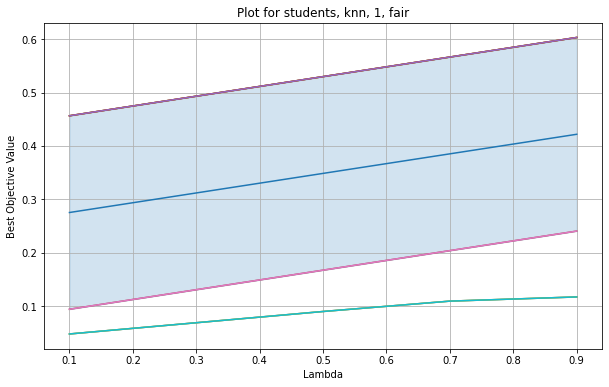

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

data = all_results

unique_tuples = data[['dataset', 'classifier', 'dataset_subset', 'method']].drop_duplicates()

plt.figure(figsize=(10, 6))
plt.title(f"Test plot")
plt.xlabel('Lambda')
plt.ylabel('Best Objective Value')
plt.grid(True)
for _, row in unique_tuples.iterrows():
    subset = data[(data['dataset'] == row['dataset']) & 
                  (data['classifier'] == row['classifier']) & 
                  (data['dataset_subset'] == row['dataset_subset']) & 
                  (data['method'] == row['method'])]

    if 'lambda' in subset.columns and 'best_objective_value' in subset.columns and (row['method'] == 'fair'):
        sns.lineplot(x='lambda', y='best_objective_value', data=subset)

plt.show()
        
